# CS229, Fall 2017
## Probelm Set 2: Supervised Learning II
### 6. Spam Classification

#### (a)

Let's first briefly review what Naive Bayes and Laplace smoothing is.

##### Naive Bayes
Naive Bayes is a generative model, which means we need to model $p(x|y)$ and make predictions according to Bayes rule.  
A model is called Naive Bayes is we use the **Naive Bayes assumption**, which is we assume $x_i$ is conditionally independent given $y$ (if I tell you an email is spam, then whether $x_{12386}$ equals to 1 or not does not effect $x_{23557}$)  
So we have:
\begin{align*}
p(x_1,\dots,x_{100}|y)&=p(x_1|y)p(x_2|y,x_1)\dots p(x_{100}|y,x_1,x_2,\dot,x_{99})\\
&=p(x_1|y)p(x_2|y)\dots p(x_{100}|y)\\
&=\prod_{i=1}^{100}p(x_i|y)
\end{align*}
The above equation is our model, as we can see, the parameters are $p(x_j|y=1)$, $p(x_j=1|y=0)$ and $p(y=1)$.  
**For generative model, given the training set, we define the likelihood to be the joint distribution**:
$$p(x^{(i)},y^{(i)})$$
After learning all parameters by maximizing the above likelihood function, we can make predictions by using Bayes rule.

##### Laplace smoothing
When we used the above way to train a model, and after that we now begin to use this model to make predictions. It is really likely that we might encounter some new words that we have never seen in our training examples. And by computing the posterior probability, we find it is
$$\frac{0}{0}$$
So, in order to avoid this problem, we will modify the maximum likelihood estimate of our parameters by:
\begin{align*}
&\phi_{j|y=1}=p(x_j=1|y=1)=\frac{\sum_{i=1}^m{\bf 1}\{x^{(i)}_j=1\bigwedge y^{(i)}=1\}+1}{\sum_{i=1}^m{\bf 1}\{y^{(i)}=1\}+2}\\
&\phi_{j|y=0}=p(x_j=1|y=0)=\frac{\sum_{i=1}^m{\bf 1}\{x^{(i)}_j=1\bigwedge y^{(i)}=0\}+1}{\sum_{i=1}^m{\bf 1}\{y^{(i)}=0\}+2}
\end{align*}

##### Event model
Differences between multi-variant Bernoulli event model and multinomial event model:
* Multi-variant Bernoulli event model: first determined if it is spam or not. Then for each word in the vocabulary, determine whether it is in or not in the email (that's why we call it Bernoulli).  
* Multinomial event model: first determined if it is spam or not. Then just like we write an email, for the i'th word in the email, we determine which word in the vocabulary we want to use (can have value other than 1 and 0).

So if we use the multinomial event model, we will have a different likelihood function, and thus a different estimation of parameters.

In [1]:
import numpy as np
import heapq
import matplotlib.pyplot as plt

In [2]:
def readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    return matrix, tokens, np.array(Y)


def nb_train(matrix, category, token_size):
    state = {}
    N = matrix.shape[1]
    M = matrix.shape[0]
    ###################
    # First, we calculate the phi_y
    index = category == 1
    phi_y = category[index].shape[0] / M
    state.update({'phi_y': phi_y})

    # Second, we calculate the phi_{k|y=1} and phi_{k|y=0}
    index_pos = category == 1
    denominator_pos = np.prod(matrix[index_pos].shape) + token_size
    index_neg = category == 0
    denominator_neg = np.prod(matrix[index_neg].shape) + token_size
    for i in range(token_size):
        matrix_one = matrix[index_pos]
        phi_k1 = (np.sum(matrix_one[:, i]) + 1) / denominator_pos
        key = 'phi_' + str(i) + '1'
        state.update({key: phi_k1})

        matrix_zero = matrix[index_neg]
        phi_k0 = (np.sum(matrix_zero[:, i]) + 1) / denominator_neg
        key = 'phi_' + str(i) + '0'
        state.update({key: phi_k0})
    ###################
    return state


def nb_test(matrix, state, token_size):
    N = matrix.shape[1]
    output = np.zeros(matrix.shape[0])
    ###################
    phi_y = state['phi_y']  # phi_y = p(y=1)
    prob_one = np.zeros(N)
    prob_zero = np.zeros(N)
    for i in range(N):
        key = 'phi_' + str(i) + '1'
        phi_1 = state[key]
        prob_one[i] = phi_1
        key = 'phi_' + str(i) + '0'
        phi_0 = state[key]
        prob_zero[i] = phi_0

    # As the result of underflow, we calculate the log probability instead
    '''
    res_one = np.prod(prob_one * matrix, 1)
    res_zero = np.prod(prob_zero * matrix, 1)
    '''
    # res_one(zero) are the summation of probability
    res_one = np.dot(matrix, np.log(prob_one))
    res_zero = np.dot(matrix, np.log(prob_zero))
    # The denominator is the same, so we can just compare the numerator
    post_prob_one = (res_one + np.log(phi_y))
    post_prob_zero = (res_zero + np.log(1 - phi_y))
    output = (post_prob_one >= post_prob_zero) + 0
    ###################
    return output


def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print('Error: %1.4f' % error)
    return error

In [3]:
def main():
    trainMatrix, tokenlist, trainCategory = readMatrix(
        './data/spam_data/MATRIX.TRAIN')
    testMatrix, tokenlist, testCategory = readMatrix(
        './data/spam_data/MATRIX.TEST')

    state = nb_train(trainMatrix, trainCategory, len(tokenlist))
    output = nb_test(testMatrix, state, len(tokenlist))

    evaluate(output, testCategory)
    return


if __name__ == '__main__':
    main()

Error: 0.0600


#### (b)

In [4]:
def nb_find_indicative(matrix, state, tokenlist):
    N = matrix.shape[1]
    phi_y = state['phi_y']  # phi_y = p(y=1)
    prob_one = np.zeros(N)
    prob_zero = np.zeros(N)
    for i in range(N):
        key = 'phi_' + str(i) + '1'
        phi_1 = state[key]
        prob_one[i] = phi_1
        key = 'phi_' + str(i) + '0'
        phi_0 = state[key]
        prob_zero[i] = phi_0

    # FInd 5 most indicative tokens
    res = np.log(prob_one / prob_zero)
    index = heapq.nlargest(5, range(len(res)), res.take)
    print('5 tokens that are most indicative of the SPAM class are: ')
    for i in index:
        print(tokenlist[i])

In [5]:
def main():
    trainMatrix, tokenlist, trainCategory = readMatrix(
        './data/spam_data/MATRIX.TRAIN')
    testMatrix, tokenlist, testCategory = readMatrix(
        './data/spam_data/MATRIX.TEST')

    state = nb_train(trainMatrix, trainCategory, len(tokenlist))
    nb_find_indicative(testMatrix, state, tokenlist)
    return


if __name__ == '__main__':
    main()

5 tokens that are most indicative of the SPAM class are: 
httpaddr
spam
unsubscrib
ebai
valet


#### (c)

Error: 0.2025
Error: 0.2100
Error: 0.1963
Error: 0.0850
Error: 0.0587
Error: 0.0512


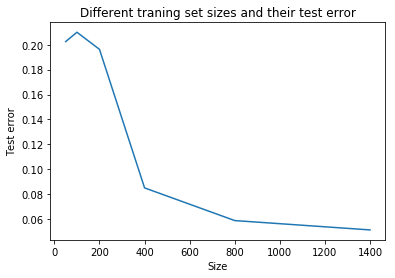

In [6]:
def main():
    sizes = [50, 100, 200, 400, 800, 1400]
    errors = []
    testMatrix, tokenlist, testCategory = readMatrix(
        './data/spam_data/MATRIX.TEST')
    for size in sizes:
        trainMatrix, tokenlist, trainCategory = readMatrix(
        './data/spam_data/MATRIX.TRAIN.' + str(size))
        state = nb_train(trainMatrix, trainCategory, len(tokenlist))
        output = nb_test(testMatrix, state, len(tokenlist))
        error = evaluate(output, testCategory)
        errors.append(error)
    
    # plot
    plt.plot(sizes, errors)
    plt.title('Different traning set sizes and their test error')
    plt.xlabel('Size')
    plt.ylabel('Test error')
    return


if __name__ == '__main__':
    main()

From the curve and the data, we can see that training set of size **1400** gives the best test set error.

#### (d)

In [9]:
import numpy as np

tau = 8.

def readMatrix(file):
    fd = open(file, 'r')
    hdr = fd.readline()
    rows, cols = [int(s) for s in fd.readline().strip().split()]
    tokens = fd.readline().strip().split()
    matrix = np.zeros((rows, cols))
    Y = []
    for i, line in enumerate(fd):
        nums = [int(x) for x in line.strip().split()]
        Y.append(nums[0])
        kv = np.array(nums[1:])
        k = np.cumsum(kv[:-1:2])
        v = kv[1::2]
        matrix[i, k] = v
    category = (np.array(Y) * 2) - 1
    return matrix, tokens, category

def svm_train(matrix, category):
    state = {}
    M, N = matrix.shape
    #####################
    Y = category
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(matrix.T)
    K = np.exp(-(squared.reshape((1, -1)) + squared.reshape((-1, 1)) - 2 * gram) / (2 * (tau ** 2)) )

    alpha = np.zeros(M)
    alpha_avg = np.zeros(M)
    L = 1. / (64 * M)
    outer_loops = 40

    alpha_avg
    for ii in range(outer_loops * M):
        i = int(np.random.rand() * M)
        margin = Y[i] * np.dot(K[i, :], alpha)
        grad = M * L * K[:, i] * alpha[i]
        if (margin < 1):
            grad -=  Y[i] * K[:, i]
        alpha -=  grad / np.sqrt(ii + 1)
        alpha_avg += alpha

    alpha_avg /= (ii + 1) * M

    state['alpha'] = alpha
    state['alpha_avg'] = alpha_avg
    state['Xtrain'] = matrix
    state['Sqtrain'] = squared
    ####################
    return state

def svm_test(matrix, state):
    M, N = matrix.shape
    output = np.zeros(M)
    ###################
    Xtrain = state['Xtrain']
    Sqtrain = state['Sqtrain']
    matrix = 1. * (matrix > 0)
    squared = np.sum(matrix * matrix, axis=1)
    gram = matrix.dot(Xtrain.T)
    K = np.exp(-(squared.reshape((-1, 1)) + Sqtrain.reshape((1, -1)) - 2 * gram) / (2 * (tau ** 2)))
    alpha_avg = state['alpha_avg']
    preds = K.dot(alpha_avg)
    output = np.sign(preds)
    ###################
    return output

def evaluate(output, label):
    error = (output != label).sum() * 1. / len(output)
    print('Error: %1.4f' % error)
    return error

Error: 0.0238
Error: 0.0213
Error: 0.0037
Error: 0.0025
Error: 0.0000
Error: 0.0000


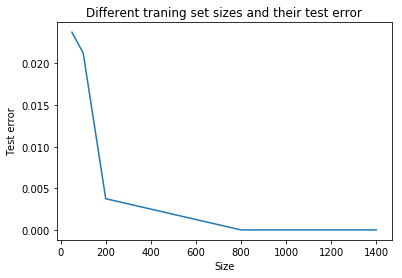

In [10]:
def main():
    sizes = [50, 100, 200, 400, 800, 1400]
    errors = []
    testMatrix, tokenlist, testCategory = readMatrix(
        './data/spam_data/MATRIX.TEST')
    for size in sizes:
        trainMatrix, tokenlist, trainCategory = readMatrix(
        './data/spam_data/MATRIX.TRAIN.' + str(size))
        state = svm_train(trainMatrix, trainCategory)
        output = svm_test(testMatrix, state)
        error = evaluate(output, testCategory)
        errors.append(error)
    
    # plot
    plt.plot(sizes, errors)
    plt.title('Different traning set sizes and their test error')
    plt.xlabel('Size')
    plt.ylabel('Test error')
    return

if __name__ == '__main__':
    main()

#### (e)

For NB, the function of generalization error and training set size first increase when the traning set size increase, and then start to decrease.  
For SVM, the function is monotonic decreasing.

Also, the generalization error of NB is higher than that of SVM.